# Scientific Authors Collaboration
Link: https://snap.stanford.edu/data/ca-HepTh.html
> This datasets contains a collaboration network that covers scientific collaborations between authors papers submitted to High Energy Physics - Theory category. If an author co-authored a paper with another author, the graph contains a undirected edge between them.

In [157]:
# Imports
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import sys
sys.path.append('../')
from utils import negative_sampling as ns, splits, features

# Const
dataset = "data/CA-HepTh.txt"
random.seed(42)

In [158]:
## Create Graph ##
G = nx.read_edgelist(dataset, nodetype=int)

print("Nodes:",len(list(G.nodes)))
print("Edges:",len(list(G.edges)))

Nodes: 9877
Edges: 25998


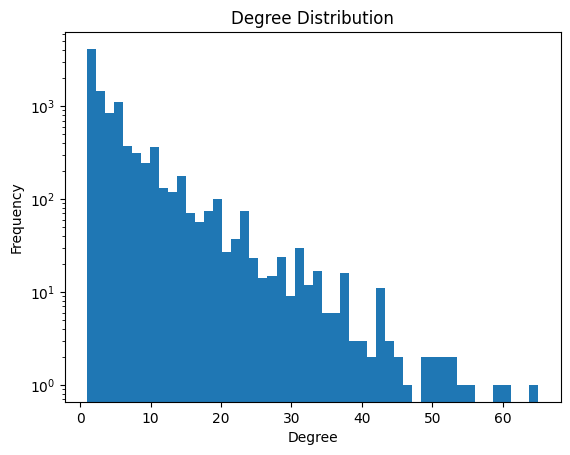

In [159]:
# Degree Distribution Plot
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=50)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.yscale("log")
plt.show()

In [160]:
# Number of connected components
print("Number of connected components:", nx.number_connected_components(G))
largest_cc = max(nx.connected_components(G), key=len)
print("Size of largest component:", len(largest_cc))

Number of connected components: 429
Size of largest component: 8638


In [161]:
# New topological features to add
def jaccard_coefficient(u, v, G):
    return nx.jaccard_coefficient(G, [(u,v)])

In [162]:
def build_feature_dataset(pairs, G, features=None):
    # Default to all features if none specified
    if features is None:
        features = ['cn', 'jc', 'aa', 'pa', 'ra']

    feature_data = {}

    if 'cn' in features:
        feature_data['cn'] = [len(list(nx.common_neighbors(G, u, v))) for u, v in pairs]

    if 'jc' in features:
        feature_data['jc'] = [coeff for _, _, coeff in nx.jaccard_coefficient(G, pairs)]

    if 'aa' in features:
        try:
            feature_data['aa'] = [coeff for _, _, coeff in nx.adamic_adar_index(G, pairs)]
        except ZeroDivisionError:
            feature_data['aa'] = [0.0] * len(pairs)

    if 'pa' in features:
        feature_data['pa'] = [coeff for _, _, coeff in nx.preferential_attachment(G, pairs)]

    if 'ra' in features:
        feature_data['ra'] = [coeff for _, _, coeff in nx.resource_allocation_index(G, pairs)]

    # Combine features in the order specified
    feature_vectors = []
    for i in range(len(pairs)):
        vector = [feature_data[feat][i] for feat in features]
        feature_vectors.append(vector)

    return feature_vectors

In [ ]:
X_train, X_test, y_train, y_test = splits.create_train_test_split(
    G,
    lambda pairs, G: build_feature_dataset(pairs, G, features=["cn", "jc", "aa", "pa", "ra"]),
    lambda: ns.random_negative_sampling(G)
)

In [164]:

def train_and_evaluate(X_train, y_train, X_test, y_test):
    ## Train on Random Forest ##
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    ## Evaluate ##
    y_pred = clf.predict_proba(X_test)[:,1] # Returns 2D with 0 and 1 class probability pairs
    auc = roc_auc_score(y_test, y_pred)
    print(f"ROC-AUC: {auc:.4f}")


train_and_evaluate(X_train, y_train, X_test, y_test)

ROC-AUC: 0.8515


ROC-AUC (cn): 0.8628

ROC-AUC (cn, jc): 0.8629

ROC-AUC (cn, jc, aa): 0.8639

ROC-AUC (cn, jc, aa, pa): 0.8515

